In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt

In [92]:
def PrintSortDict(sd):
    for k in sd.keys():
        print(f"{k}: {sd[k]}")

def PrintKeys(sd):
    for k in sd.keys():
        print(f"{k}; ")

def PrintScope(sd):
    for k in sd.keys():
        print(f"Vizinhos de {k.id}: ")
        for kk in sd[k].keys():
            print(f"{kk.id}: {sd[k][kk]}")

In [257]:
class Point:
    #id = 1
    def __init__(self,a,b, c = 0, shake=1e-5):
        #self.id = Point.id
        #Point.id+=1
        shakes = np.random.uniform(-shake, shake, 2)
        self.x = a+shakes[0]
        self.y = b+shakes[1]
        self.classe = c

    def __add__(self, other):
        if isinstance(other, Point):
            return Point(self.x+other.x, self.y+other.y)
        elif isinstance(other, np.ndarray):
            return Point(self.x+other[0],self.y+other[1],shake=0)
        else:
            raise TypeError("Unsupported operand type")
        
    def __sub__(self, other):
        if isinstance(other, Point):
            return Point(self.x-other.x, self.y-other.y)
        else:
            raise TypeError("Unsupported operand type")
        
    def __str__(self):
        return str(self.id)+": "+str(self.x)+"   "+str(self.y)
    

    def __lt__(self,other):
        if isinstance(other, Point):
            vec_prod = (self.x*other.y)-(self.y*other.x)
            if vec_prod>0:
                return True
            elif vec_prod<0 or (self.x==other.x and self.y==other.y):
                return False            
            else:
                raise Exception(f"Segments ending in {self} and {other} are parallel")
        else:
            raise TypeError("Unsupported operand type")
        
    
        
    def Shake(self,shake):
        shakes = np.random.uniform(-shake,shake,2)
        self.x+=shakes[0]
        self.y+=shakes[1]
        return self

    def Reset():
        Point.id = 1

def X_Coord(point):
    return point.x

In [76]:
class Segment:
    id = 1
    def __init__(self,a: Point, b: Point, enforce_order=True, shake = 0):
        if b.x<a.x and enforce_order:
            temp = a
            a = b
            b = temp
        self.bgn = a.Shake(shake)
        self.end = b.Shake(shake)
        self.slope = (self.end.y-self.bgn.y)/(self.end.x-self.bgn.x)
        self.intercept = self.end.y - (self.slope * self.end.x)
        self.id = Segment.id
        Segment.id+=1
        
    
    def Y_At_X(self,x):
        return self.slope*x+self.intercept


    def Invert(self):
        temp = self.bgn
        self.bgn = self.end
        self.end = temp


    def __str__(self):
        return "Id: "+str(self.id)+"\nBegin: "+str(self.bgn.x)+"   "+str(self.bgn.y)+"\nEnd: "+str(self.end.x)+"   "+str(self.end.y)
    
    def __lt__(self,other):
        if isinstance(other, Segment):
            return self.bgn.x < other.bgn.x
        else:
            raise TypeError("Unsupported operand type")
        
    def Reset():
        Segment.id = 1

In [7]:
class LimitPoint:
    def __init__(self,p,i):
        self.point = p
        self.is_end = i

    def __lt__(self,other):
        if isinstance(other, LimitPoint):
            return self.point.x < other.point.x
        else:
            raise TypeError("Unsupported operand type")

In [230]:
class PointWrap:
    def __init__(self,pt: Point):
        self.p = pt

    def __lt__(self,other):
        return self.p.x<other.p.x

## Primitivas

In [70]:
def Clockwise(a: Segment, b: Segment): #returns true if a is clockwise to b
    frst_seg = a.end - a.bgn
    scnd_seg = b.end - b.bgn
    vec_prod = (frst_seg.x*scnd_seg.y)-(frst_seg.y*scnd_seg.x)
    if vec_prod>0:
        return True
    elif vec_prod<0:
        return False
    else:
        print(a)
        print(b)
        raise Exception("Segments are parallel")

In [9]:
def SegmentsIntercept(a: Segment,b: Segment):
    check_one = Clockwise(a,Segment(a.bgn,b.bgn))
    check_two = Clockwise(a,Segment(a.bgn,b.end))
    if check_one==check_two:
        return False
    check_one = Clockwise(b,Segment(b.bgn,a.bgn))
    check_two = Clockwise(b,Segment(b.bgn,a.end))
    if check_one==check_two:
        return False
    return True

## Data reading and pre-processing

In [10]:
def SetTwoDimensions(df):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = pca_result, columns = ['x', 'y'])
    return df_pca

In [11]:
def PreProcessData(path, tgtCol):
    df = pd.read_csv(path)
    tgtData = df.iloc[:, tgtCol]  # Save the nth column
    df = df.drop(df.columns[tgtCol], axis=1)
    df = SetTwoDimensions(df)
    df['target_data'] = tgtData
    return df

In [12]:
def ExtractPoints(df):
    rb_tree_points = SortedDict(X_Coord)
    for i in range(len(df)):
        p = Point(df.loc[i, "x"], df.loc[i, "y"], df.loc[i,"target_data"])
        rb_tree_points[p] = None
    return rb_tree_points


In [13]:
def ReadData(path, tgtCol):
    df = PreProcessData(path, tgtCol)
    rb_tree_points = ExtractPoints(df)
    return rb_tree_points


## Convex Hull

In [104]:
def get_next_key(sd, key):
    idx = sd.bisect(key)
    return sd.iloc[idx] if idx < len(sd) else sd.iloc[0]

def get_previous_key(sd, key):
    idx = sd.bisect_left(key)
    return sd.iloc[idx - 1] if idx > 0 else sd.iloc[len(sd)-1]

In [14]:
def print_convex_hull(hull,points):
    polar_hull = SortedDict()
    for key in hull.keys():
        polar_hull[key] = None

    keys = list(polar_hull.keys())
    x = []
    y = []
    for key in polar_hull.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])

    ps = []
    for p in points.items():
        ps.append(p[0])
    xs = list(map(lambda p:p.x,ps))
    ys = list(map(lambda p:p.y,ps))

    plt.plot(x,y)
    plt.scatter(xs,ys)
    plt.show()

In [15]:
def ConvexHull(rb_tree_points):
    hull_points = SortedDict(lambda p:p.x)

    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]

    hull_points[p0] = None
    hull_points[p1] = None
    hull_points[p2] = None
    
    print_convex_hull(hull_points,rb_tree_points)

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        j = -1
        
        #Update upper bound
        u = j
        p_i_m1 = (j-1) % len(hull_points)
        
        while(Clockwise(
                        Segment(hull_points.items()[p_i_m1][0],p),
                        Segment(hull_points.items()[p_i_m1][0],hull_points.items()[u][0])
                        )):
            if(u != j):
                hull_points.pop(hull_points.items()[u][0])
            u = (u-1)%len(hull_points)
            p_i_m1 = (u-1)%len(hull_points)
        
        #Update lower bound
        l = 0
        p_i_p2 = (l+1) % len(hull_points)

        while(Clockwise(
                        Segment(p,hull_points.items()[l][0]),
                        Segment(p,hull_points.items()[p_i_p2][0])
                        )
            ):
            if(l != u):
                hull_points.pop(hull_points.items()[l][0])
            l = (l+1)%len(hull_points)
            p_i_p2 = (l+1)%len(hull_points)
        
        # Necessário encontrar uma função que insira o ponto em uma posição específica do ponto
        hull_points[p] = None
        print_convex_hull(hull_points,rb_tree_points)
    return hull_points

In [202]:
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None

rbt.pop(p1)

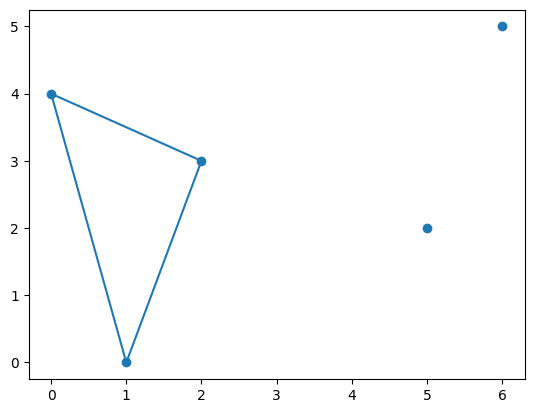

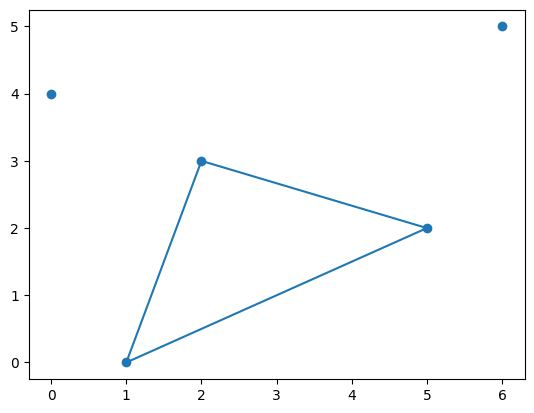

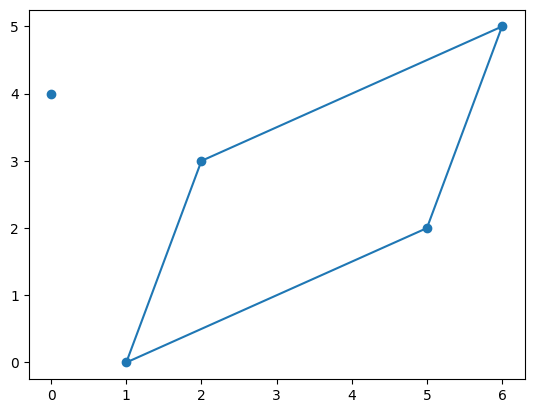

In [16]:
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None

ch = ConvexHull(rbt)

In [85]:
def PrintHullA(polar_hull):
    x = []
    y = []
    for key in polar_hull.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y, marker='o', color='b')

def PrintPoints(rb):
    x = []
    y = []
    for k in rb.keys():
        x.append(k.x)
        y.append(k.y)
    plt.scatter(x,y)

In [258]:
def ConvexHullA(rb_tree_points):
    #hull_points = SortedDict()
    polar_hull = SortedDict()
    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]
    #hull_points[PointWrap(p0)] = None
    #hull_points[PointWrap(p1)] = None
    #hull_points[PointWrap(p2)] = None
    polar_hull[p0] = None
    polar_hull[p1] = None
    polar_hull[p2] = None

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        polar_hull[p] = None
        n = len(polar_hull)
        index_cclock_comparable = (polar_hull.index(p)+1)%n
        compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull
        searching_cclock = True


        index_clock_comparable = (polar_hull.index(p)-1)%n
        compare_clock = polar_hull.iloc[index_clock_comparable]      #first element to search clockwise the vertex that links to p in the old hull
        searching_clock = True
        #PrintKeys(polar_hull) ###
        del polar_hull[p]
        n = len(polar_hull)
        removal = dict()
        #searching for parallel segment counter_clockwise
        #print(f"The new point is {p}")
        while searching_cclock:
            index_cclock_comparable = polar_hull.index(compare_cclock)
            #print(f"The anchor is {compare_cclock}")
            window = [(index_cclock_comparable-1)%n, (index_cclock_comparable+1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_cclock, enforce_order=False,shake=1e-5)
            seg2 = Segment(compare_cclock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)
            seg0 = Segment(compare_cclock, p, enforce_order=False, shake=1e-5)
            
            #print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2{seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                #print("Found")
                searching_cclock = False
            else:
                #print("Mark to remove:")
                #print(compare_cclock)
                removal[compare_cclock] = None
                #print("marked")
                compare_cclock = polar_hull.iloc[window[1]]

        #searching for parallel segment clockwise
        while searching_clock:
            index_clock_comparable = polar_hull.index(compare_clock)
            #print(f"The anchor is {compare_clock}")
            window = [(index_clock_comparable+1)%n, (index_clock_comparable-1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_clock, enforce_order=False,shake=1e-5)##
            seg2 = Segment(compare_clock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)##
            seg0 = Segment(compare_clock, p, enforce_order=False,shake=1e-5)
            #print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2: {seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                #print("Found")
                searching_clock = False
            else:
                #print("Mark to remove:")
                #print(compare_clock)
                removal[compare_clock] = None
                #print("marked")
                compare_clock = polar_hull.iloc[window[1]]
        #print("removal")
        for to_remove in removal:
            #print(to_remove)
            #PrintKeys(polar_hull)
            del polar_hull[to_remove]
            #print("after removal")
            #PrintKeys(polar_hull)
    
        polar_hull[p] = None
        #hull_points[p] = None
    return polar_hull

/tmp/ipykernel_5001/924946608.py:19: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull


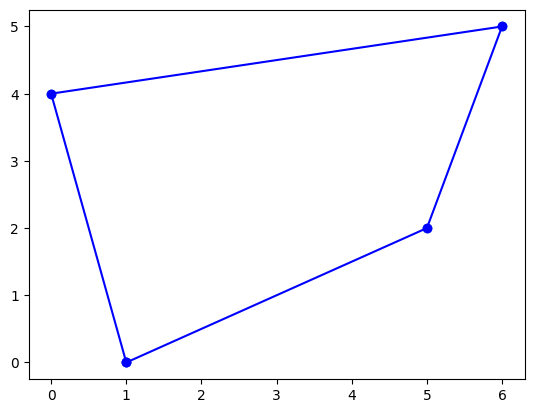

In [260]:
Point.Reset()
Segment.Reset()
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None
#PrintPoints(rbt)
ph = ConvexHullA(rbt)
PrintPoints(ph)
PrintHullA(ph)

In [227]:
def ConvexHullA_BUG_NO_SISTEMA_ALGUEM_ME_DESCONFIGUROU(rb_tree_points):
    hull_points = SortedDict(X_Coord)
    polar_hull = SortedDict()
    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]
    hull_points[p0] = None
    hull_points[p1] = None
    hull_points[p2] = None
    polar_hull[p0] = None
    polar_hull[p1] = None
    polar_hull[p2] = None

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        polar_hull[p] = None
        n = len(polar_hull)
        index_cclock_comparable = (polar_hull.index(p)+1)%n
        compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull
        searching_cclock = True


        index_clock_comparable = (polar_hull.index(p)-1)%n
        compare_clock = polar_hull.iloc[index_clock_comparable]      #first element to search clockwise the vertex that links to p in the old hull
        searching_clock = True
        PrintKeys(polar_hull) ###
        polar_hull.pop(p,0)
        n = len(polar_hull)
        removal = dict()
        #searching for parallel segment counter_clockwise
        print(f"The new point is {p}")
        while searching_cclock:
            index_cclock_comparable = polar_hull.index(compare_cclock)
            print(f"The anchor is {compare_cclock}")
            window = [(index_cclock_comparable-1)%n, (index_cclock_comparable+1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_cclock, enforce_order=False,shake=1e-5)
            seg2 = Segment(compare_cclock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)
            seg0 = Segment(compare_cclock, p, enforce_order=False, shake=1e-5)
            
            print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2{seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                print("Found")
                searching_cclock = False
            else:
                print("Mark to remove:")
                print(compare_cclock)
                removal[compare_cclock] = None
                print("marked")
                compare_cclock = polar_hull.iloc[window[1]]

        #searching for parallel segment clockwise
        while searching_clock:
            index_clock_comparable = polar_hull.index(compare_clock)
            print(f"The anchor is {compare_clock}")
            window = [(index_clock_comparable+1)%n, (index_clock_comparable-1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_clock, enforce_order=False,shake=1e-5)##
            seg2 = Segment(compare_clock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)##
            seg0 = Segment(compare_clock, p, enforce_order=False,shake=1e-5)
            print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2: {seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                print("Found")
                searching_clock = False
            else:
                print("Mark to remove:")
                print(compare_clock)
                removal[compare_clock] = None
                print("marked")
                compare_clock = polar_hull.iloc[window[1]]
        print("polar")
        PrintKeys(polar_hull)

        print("cartesian")
        PrintKeys(hull_points)
        for to_remove in removal:
            polar_hull.pop(to_remove,0)
            for key in hull_points.keys(): ###key saiu de hull_points
                if key==to_remove: 
                    print(hull_points[key])###Bug porque não consegue achar key em hull_points
                    hull_points.pop(key,0) ###Bug porque não consegue achar key em hull_points
        polar_hull[p] = None
        hull_points[p] = None
    return hull_points, polar_hull

In [228]:
Point.Reset()
Segment.Reset()
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None
#PrintPoints(rbt)
ch, ph = ConvexHullA_BUG_NO_SISTEMA_ALGUEM_ME_DESCONFIGUROU(rbt)
PrintPoints(ch)
#PrintHullA(ph)

1: 0.9999953698336884   8.028341784328267e-06; 
1: 4.99999500181063   1.9999991963259682; 
1: 2.000001953875632   2.999995544488001; 
1: -1.1962782356079255e-06   3.999995704587596; 
The new point is 1: 4.99999500181063   1.9999991963259682
The anchor is 1: 2.000001953875632   2.999995544488001
Segments:
seg0: Id: 3
Begin: 2.000000964832397   2.9999830012150284
End: 4.999990397519347   1.999991716234382
seg1: Id: 1
Begin: -9.756217016678505e-06   4.000000800939768
End: 2.000000964832397   2.9999830012150284
seg2Id: 2
Begin: 2.000000964832397   2.9999830012150284
End: 0.999987650897936   1.563553828504163e-05
Mark to remove:
1: 2.000000964832397   2.9999830012150284
marked
The anchor is 1: -9.756217016678505e-06   4.000000800939768
Segments:
seg0: Id: 6
Begin: -6.433758676381956e-07   4.000004068156155
End: 4.999994844141713   1.9999940765885174
seg1: Id: 4
Begin: 0.9999890476272238   1.2410928354938653e-05
End: -6.433758676381956e-07   4.000004068156155
seg2Id: 5
Begin: -6.433758676381

/tmp/ipykernel_5001/1083050540.py:19: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull


KeyError: <__main__.Point object at 0x7f704de32130>

## Sweep Line

In [65]:
def GetSegments(polar_hull):
    #polar_hull = SortedDict()
    #for key in convex_hull.keys():
    #    polar_hull[key] = None
    n = len(polar_hull)
    keys = list(polar_hull.keys())
    segments_hull = SortedDict()
    count = 0
    for key in polar_hull.keys():
        shake = np.random.uniform(0, 1e-5, (2,2))
        next_key = keys[(count + 1) % n]
        if key.x<next_key.x:
            shake[1][0] *= -1
        else:
            shake[0][0] *= -1
        if key.y<next_key.y:
            shake[1][1] *= -1
        else:
            shake[0][1] *= -1
        s = Segment(key+shake[0],next_key+shake[1])
        count+=1
        segments_hull[s.bgn.x] = (s,0)
        segments_hull[s.end.x] = (s,1)
    return segments_hull

In [54]:
def SweepLine(segment_hull_one, segments_hull_two):
    segments_set = segment_hull_one.copy()
    segments_set.update(segments_hull_two)
    scope = SortedDict()
    for key in segments_set.keys():
        print(key)
        current_segment, end = segments_set[key]
        if not end: #início do segmento
            print(f"Início do segmento {current_segment.id}")
            comparisons = dict()
            for comparable_segment in scope.keys():
                aux = (current_segment.bgn.y>comparable_segment.Y_At_X(key))
                comparisons[comparable_segment] = aux
                scope[comparable_segment][current_segment] = not aux
            scope[current_segment] = comparisons
            PrintScope(scope)
            
        else:                          #fim do segmento
            print(f"Fim do segmento {current_segment.id}")
            comparisons = scope[current_segment]
            PrintScope(scope)
            del scope[current_segment]
            for comparable_segment in scope.keys():
                aux = (current_segment.end.y>comparable_segment.Y_At_X(key))
                if comparisons[comparable_segment] != aux:
                    print(f"Inteseção entre {current_segment.id} e {comparable_segment.id}")
                    return True
            
    return False

## Display

## Testing

In [19]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
Point.Reset()
polar_set = SortedDict()      #Points are being sorted according to polar coordinate
polar_set[p1] = None
polar_set[p2] = None
polar_set[p3] = None
for key in polar_set.keys():
    print(key)

1: 1.0   0.0
3: 2.0   2.0
2: 0.0   2.0


In [20]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
p4 = Point(2,3, shake=0)
p5 = Point(1.5,3, shake=0)
p6 = Point(0.003,3, shake=0)
Point.Reset()
xc_set = SortedDict(X_Coord)      #Points are being sorted according to x coordinate
xc_set[p1] = None
xc_set[p2] = None
xc_set[p3] = None
xc_set[p4] = None
xc_set[p5] = None
xc_set[p6] = None
for key in xc_set.keys():
    print(key)

2: 0.0   2.0
6: 0.003   3.0
1: 1.0   0.0
5: 1.5   3.0
3: 2.0   2.0
4: 2.0   3.0


In [61]:
Segment.Reset()
Point.Reset()
p1 = Point(-1,0)
p2 = Point(1,0)
p3 = Point(-2,1)
p4 = Point(2,1)
p5 = Point(0,3)
pentagon = SortedDict()
pentagon[p1] = None
pentagon[p2] = None
pentagon[p3] = None
pentagon[p4] = None
pentagon[p5] = None
pentagon_seg = GetSegments(pentagon)       #working
for k in pentagon_seg.keys():
    if pentagon_seg[k][1]==0:
        print(pentagon_seg[k][0])
    print("\n")

Id: 3
Begin: -2.0000039313571647   0.9999996329147003
End: 9.048951265765937e-07   2.99999051595714


Id: 4
Begin: -2.000003313637459   0.9999865392849401
End: -1.0000117008959437   -6.150627532354475e-07




Id: 5
Begin: -0.9999961875996614   2.4184664802792496e-06
End: 0.9999923895427073   1.7496775274616193e-06




Id: 2
Begin: 5.899833563079798e-06   2.999994829621399
End: 1.9999972934421957   1.0000046112046976




Id: 1
Begin: 1.000000666346875   1.1286267650843265e-05
End: 1.9999982400709564   0.9999949040526644








In [62]:
Point.Reset()
p1 = Point(0,2)
p2 = Point(3,0)
p3 = Point(3,3)
triangle = SortedDict()
triangle[p1] = None
triangle[p2] = None
triangle[p3] = None
triangle_seg = GetSegments(triangle)
for k in triangle_seg.keys():
    if triangle_seg[k][1]==0:
        print(triangle_seg[k][0])
    print("\n")


Id: 8
Begin: 7.71155110331482e-06   1.999994075201285
End: 2.9999975929264884   9.207837987459124e-06


Id: 7
Begin: 1.1830067633337844e-05   2.0000040477296013
End: 2.999987904670778   2.9999950343574144




Id: 6
Begin: 2.9999970052550227   1.0786915601523008e-05
End: 2.9999970172241306   2.9999954669272184








In [63]:
SweepLine(triangle_seg,pentagon_seg)

-2.0000039313571647
Início do segmento 3
Vizinhos de 3: 
-2.000003313637459
Início do segmento 4
Vizinhos de 3: 
4: True
Vizinhos de 4: 
3: False
-1.0000117008959437
Fim do segmento 4
Vizinhos de 3: 
4: True
Vizinhos de 4: 
3: False
-0.9999961875996614
Início do segmento 5
Vizinhos de 3: 
4: True
5: True
Vizinhos de 5: 
3: False
9.048951265765937e-07
Fim do segmento 3
Vizinhos de 3: 
4: True
5: True
Vizinhos de 5: 
3: False
5.899833563079798e-06
Início do segmento 2
Vizinhos de 5: 
3: False
2: False
Vizinhos de 2: 
5: True
7.71155110331482e-06
Início do segmento 8
Vizinhos de 5: 
3: False
2: False
8: False
Vizinhos de 2: 
5: True
8: True
Vizinhos de 8: 
5: True
2: False
1.1830067633337844e-05
Início do segmento 7
Vizinhos de 5: 
3: False
2: False
8: False
7: False
Vizinhos de 2: 
5: True
8: True
7: True
Vizinhos de 8: 
5: True
2: False
7: False
Vizinhos de 7: 
5: True
2: False
8: True
0.9999923895427073
Fim do segmento 5
Vizinhos de 5: 
3: False
2: False
8: False
7: False
Vizinhos de 2

True